## Gaussian Process Regression 

A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution. It is completely characterized by a mean function, $m(\mathbf{x})$, and covariance function, $k(\mathbf{x,x'})$: 

\begin{equation*}
    f(\mathbf{x}) \sim \mathcal{GP} \big( m(\mathbf{x}), k(\mathbf{x, x'}) \big) \, , 
\end{equation*}

where its mean and covariance functions are defined as: 

\begin{equation*}
    \begin{aligned}
        m(\mathbf{x})    & = \mathbb{E}[f(\mathbf{x})] \\
        k(\mathbf{x,x'}) & = \mathbb{E}[f(\mathbf{x}) - m(\mathbf{x}) (f(\mathbf{x'}) - m(\mathbf{x'}) ) ] \, .  
    \end{aligned}
\end{equation*}

$k(\mathbf{x,x'})$ specifies the covariance between pairs of random variables, one example of which is the squared exponential (SE) function: 

\begin{equation*}
    cov \big( f(\mathbf{x}_p), f(\mathbf{x}_q) \big) = k(\mathbf{x}_p ,\mathbf{x}_q ) = exp \big( -\tfrac{1}{2} | \mathbf{x}_p  -\mathbf{x}_q |^2 \big) . 
\end{equation*}

### 1D example 

In [8]:
using GaussianProcesses 
using Random 

Random.seed!(0) 

# create training data
n = 10 ;                        # number of training points 
x_train = 2π * rand(n) ;              # predictors 
y_train = sin.(x_train) + 0.1 * randn(n) ;  # measurements / data / regressors 

# mean and covariance 
mZero = MeanZero() ;            # zero mean function 
kern  = SE(1.0, 1.0) ;          # squared eponential kernel (hyperparams on log scale) 
log_noise = -1.0 ;              # (optional) log std dev of obs noise 

# fit GP 
gp  = GP(x_train, y_train, mZero, kern, log_noise) ; 

display(gp) 

GP Exact object:
  Dim = 1
  Number of observations = 10
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: SEIso{Float64}, Params: [1.0, 1.0]
  Input observations = 
[2.8603473258787426 3.4409389943447213 … 0.5463031630773676 2.2084855205094454]
  Output observations = [0.2751276073098585, -0.33331579692863816, -0.9313858944982316, -0.21794061993930058, 0.008563243458792558, -0.9389399827722761, -1.0138179212797565, -0.0624936805142621, 0.4266167884764185, 0.8113628276418366]
  Variance of observation noise = 0.1353352832366127
  Marginal Log-Likelihood = -8.855

Now, use `predict_y` to predict function $\mathbf{f^*}$: 

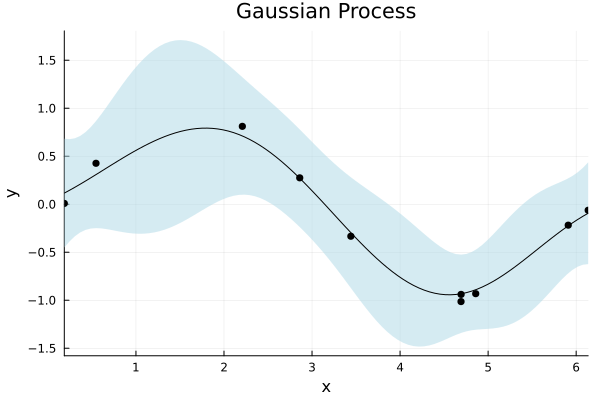

In [3]:
# predict function  
x_test = range(0, stop=2π, length=100) ; 
μ, σ² = predict_y( gp, x_test ) 

# plot 
using Plots 
plot(gp; xlabel="x", ylabel="y", title="Gaussian Process", legend=false, fmt=:png) 



By default, all hyperparameters are optimized. The function `optimize!` can force hyperparameters to remain constant or optimized separately. 

In [7]:
# don't optimize kernel hyperparameters 
optimize!(gp; kern = false) ; 

# optimize in a box with lower bounds [-1,-1] and upper bounds [1,1]
optimize!(gp; kernbounds = [ [-1,-1] , [1,1] ])


 * Status: success

 * Candidate solution
    Final objective value:     -2.310286e+00

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 7.09e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 2.03e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.35e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    3
    f(x) calls:    35
    ∇f(x) calls:   35


### Multi-dimensional regression 

Consider a 2-dimensional regression example: 

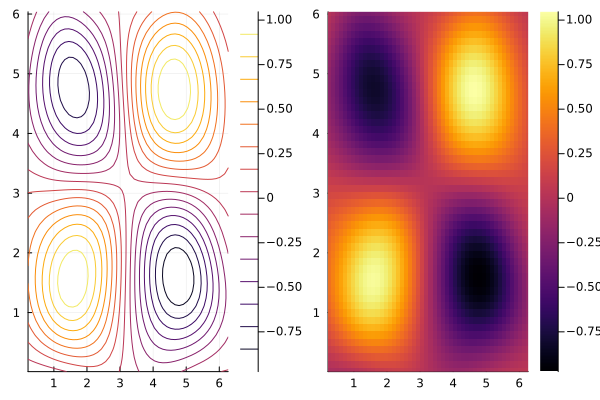

In [8]:
# training data
d = 2 ;                 # dimension 
n = 50 ;                # number of observations 
x = 2π * rand(d, n) ;   # predictors 
y = vec( sin.(x[1,:]) .* sin.(x[2,:]) )  + 0.1 * rand(n) ; 

# mean function and kernel 
mZero = MeanZero() ; 
kern  = SE(0.0, 0.0) ; 

# fit GP 
gp = GP(x, y, mZero, kern, -2.0) ; 

# plot 
plot(contour(gp), heatmap(gp); fmt=:png)


In [9]:
display(gp) 

GP Exact object:
  Dim = 2
  Number of observations = 50
  Mean function:
    Type: MeanZero, Params: Float64[]
  Kernel:
    Type: SEIso{Float64}, Params: [0.0, 0.0]
  Input observations = 
[4.257625167699848 3.9837672362935628 … 0.931469585935617 3.689526500912118; 4.056685829608313 3.5159722699677953 … 1.4511273853701017 5.273498951574682]
  Output observations = [0.7590690850683768, 0.27972777280365324, -0.29673199442991227, -0.2898574057383345, -0.7293212937880461, 0.6139279556467288, -0.36038938245964647, -0.8347871897854533, 0.11636158556600668, 0.10342711562644  …  -0.4649436517383798, 1.003243176554892, 0.637398231532897, -0.19999621739271334, -0.6459421225953208, 0.5087519519555692, 0.0826089483178736, -0.7550477050971621, 0.8283211232049459, 0.5328315703158977]
  Variance of observation noise = 0.01831563888873418
  Marginal Log-Likelihood = -10.003

## Gaussian Processes from Scratch 

Okay, let's just try to do this from scratch ... 



In [10]:
# true hyperparameters 
sig_f0 = 1 ; 
l0     = 1 ; 
sig_n0 = 0.1 ; 

# generate training data 
N = 5 ; 
x_train = sort( 10*rand(N,1), dims=1 )      # matrix     
x_train = [ 1.0343 2.8932 4.1403 5.1443 5.3743 ] ; 

# x_train = sort( 10*rand(N) )              # vector 
display(size(x_train)) 

# define square distance function 
function sq_dist(a::Matrix, b::Matrix) 

    # extract dims 
    D, n = size(a) ;  
    d, m = size(b) ;

    # ensure a, b are "row" matrices 
    if D > n 
        a = transpose(a) ; 
        D, n = size(a) ; 
    end 
    if d > m 
        b = transpose(b) ; 
        d, m = size(b) ; 
    end 

    # iterate 
    C = zeros(n,m) ; 
    for d = 1:D 
        amat = repeat(transpose(a), outer = [1,m]) ; 
        bmat = repeat(b, outer = [n,1]) ; 
        C += (bmat - amat).^2 ; 
    end 

    return C 

end 

test = sq_dist(x_train, x_train) 
display(test) 


(1, 5)

5×5 Matrix{Float64}:
  0.0      3.45551  9.64724  16.8921   18.8356
  3.45551  0.0      1.55526   5.06745   6.15586
  9.64724  1.55526  0.0       1.00802   1.52276
 16.8921   5.06745  1.00802   0.0       0.0529
 18.8356   6.15586  1.52276   0.0529    0.0

Now create some training data: 

In [11]:
# covariance function from kernel 

k_fn(sig_f, l, xp, xq) = sig_f^2 * exp.( -1/( 2*l^2 ) * sq_dist(xp, xq) ) ; 

using LinearAlgebra 

sigma = k_fn( sig_f0, l0, x_train, x_train ) 
sigma += sig_n0^2 * I 

# sample from given mean and covariance 
function gauss_sample(mu::Matrix, K::Matrix, n) 

    # ENSURE MU IS COLUMN 
    r, p = size(mu) ; 
    if p > r 
        mu = transpose(mu) ; 
        r, p = size(mu) ; 
    end 
    
    # cholesky decomposition, get lower triangular decomp 
    C = cholesky(K) ; 
    L = C.L ; 

    # draw random samples 
    u = randn(length(mu), n) ; 

    # fs ~ N(0, K(xs, xs)) 
    f = mu + L*u ; 

    return f 

end 

# training data --> "measured" output at x_train 
y = gauss_sample(0*x_train, sigma, 1) ;



Now define the covariance function from the kernel. Prior distribution 

In [12]:
## prior distribution 

# generate test data x-star = test data 
dx = 0.1 ; 
x_test = collect(0 : dx : 10.0) ;

# x_test_mat = mapreduce(permutedims, vcat, x_test) ; 
x_test = reshape(x_test, length(x_test), 1) 
display(size(x_test) )

# mean function 
mu_fn(x) = 0 .* x ; 
mu_prior = mu_fn(x_test) ; 

# prior covariance 
Kss = k_fn(sig_f0, l0, x_test, x_test) ; 
S_prior = Kss + sig_n0^2 * I ; 


(101, 1)

Posterior distribution, conditional distribution, and draw random samples! 

In [66]:
## posterior distribution 
# k_fn(sig_f, l, xp, xq) = sig_f^2 * exp.( -1/( 2*l^2 ) * sq_dist(xp, xq) ) ; 

K  = k_fn(sig_f0, l0, x_train, x_train) ; 
K  += sig_n0^2 * I ; 
Ks = k_fn(sig_f0, l0, x_train, x_test) ;  

display(eigvals(K)) 
# display(eigvals(Ks)) 
display(eigvals(Kss))


# conditional distribution 
mu_post = Ks' * inv(K) * y ; 
S_post  = Kss - ( Ks' * inv(K) * Ks ) ; 

m,n = size(S_post) 

test = 0*S_post ; 
for i = 1:m 
    for j = 1:n 
        test[i,j] = round(S_post[i,j], digits = 13) 
    end 
end 

# draw random samples from posterior distribution 
# f_post  = gauss_sample(mu_post, S_post + sig_n0^2 * I , 5) ; 

# test = S_post + sig_n0 * I ; 
C = cholesky(test) 
display(C.L) 

# test = ( Ks' * inv(K) * Ks ) ; 
# test == test' 

# test 


# S_post[1:3,1:3]


5-element Vector{Float64}:
 0.02081753008318095
 0.37485345222661404
 0.9296696934253919
 1.2606001537050973
 2.4640591705597155

101-element Vector{Float64}:
 -4.694898955116726e-15
 -3.9626352520934634e-15
 -3.374896959992597e-15
 -2.1377825639248908e-15
 -1.6824668308587055e-15
 -1.5642719789606268e-15
 -1.4091609814871671e-15
 -1.311068160722048e-15
 -1.2134495208352926e-15
 -8.866555473943305e-16
 -8.044497484033301e-16
 -7.570014285872554e-16
 -6.640883651397982e-16
  ⋮
  0.12539763750210425
  0.281467005798102
  0.5956597789372746
  1.1855544061056604
  2.2134968709370355
  3.8667982027453407
  6.304707402826322
  9.572707120929522
 13.508371188130667
 17.687282946724764
 21.46152362299763
 24.110906275933658

LoadError: PosDefException: matrix is not Hermitian; Cholesky factorization failed.

Draw random samples! 